In [1]:
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import scipy.stats as stats
import numpy as np
from adjustText import adjust_text
pd.options.display.float_format = '{:.2f}'.format

# Data Loads

In [2]:
## state COLI
state_abbreviations = {
    'Alabama': 'al',
    'Alaska': 'ak',
    'Arizona': 'az',
    'Arkansas': 'ar',
    'California': 'ca',
    'Colorado': 'co',
    'Connecticut': 'ct',
    'Delaware': 'de',
    'Florida': 'fl',
    'Georgia': 'ga',
    'Hawaii': 'hi',
    'Idaho': 'id',
    'Illinois': 'il',
    'Indiana': 'in',
    'Iowa': 'ia',
    'Kansas': 'ks',
    'Kentucky': 'ky',
    'Louisiana': 'la',
    'Maine': 'me',
    'Maryland': 'md',
    'Massachusetts': 'ma',
    'Michigan': 'mi',
    'Minnesota': 'mn',
    'Mississippi': 'ms',
    'Missouri': 'mo',
    'Montana': 'mt',
    'Nebraska': 'ne',
    'Nevada': 'nv',
    'New Hampshire': 'nh',
    'New Jersey': 'nj',
    'New Mexico': 'nm',
    'New York': 'ny',
    'North Carolina': 'nc',
    'North Dakota': 'nd',
    'Ohio': 'oh',
    'Oklahoma': 'ok',
    'Oregon': 'or',
    'Pennsylvania': 'pa',
    'Rhode Island': 'ri',
    'South Carolina': 'sc',
    'South Dakota': 'sd',
    'Tennessee': 'tn',
    'Texas': 'tx',
    'Utah': 'ut',
    'Vermont': 'vt',
    'Virginia': 'va',
    'Washington': 'wa',
    'West Virginia': 'wv',
    'Wisconsin': 'wi',
    'Wyoming': 'wy',
    'District of Columbia': 'dc',
    'Puerto Rico': 'pr',
    'Guam': 'gu',
    'American Samoa': 'as',
    'U.S. Virgin Islands': 'vi',
    'Northern Mariana Islands': 'mp'
}

# Replace state names with their abbreviations

state_coli = pd.read_csv('data/demographic_data/world_population_review_coli.csv')

state_coli['abbrev'] = state_coli['State'].replace(state_abbreviations)



In [3]:
## city COLI

city_coli = pd.read_csv('data/demographic_data/advisorsmith_cost_of_living_index.csv')
city_coli.columns = [x.lower() for x in city_coli.columns]
city_coli['city'] = city_coli['city'].str.lower()
city_coli['state'] = city_coli['state'].str.lower()
city_coli

,city,state,cost of living index
0,abilene,tx,89.10
1,adrian,mi,90.50
2,akron,oh,89.40
3,alamogordo,nm,85.80
4,albany,ga,87.30
...,...,...,...
505,wheeling,wv,84.10
506,new london,ct,105.90
507,daphne,al,96.60
508,victoria,tx,89.50


In [4]:
with open('data/spring_2023/full_df.pkl', 'rb') as file:
    full_df = pkl.load(file)

len(full_df)

1247140

In [5]:

full_df = full_df.drop_duplicates(subset = ['item_name', 'store_id']) # need this because the same item might be listed under multiple categories
len(full_df)

full_df['state'], full_df['city'] = zip(*full_df['location_url'].str.split('/').str[3:5])

# Aggregations

In [6]:

core_items = [
              'Supreme Taco Party Pack', 
            #   'Chicken Quesadilla', 
            #   'Cinnabon Delights® 12 Pack', 
            #   'Crunchwrap Supreme®', 
            #   'Beefy 5 Layer Burrito', 
            #   'Nacho Cheese Doritos Locos Taco', 
            #   '3 Doritos Locos Tacos Combo'
              ]

working = full_df[full_df['item_name'].isin(core_items)]

In [7]:
# working.head()
# city_distro[city_distro['num_stores'] != 1]
# working[working['city'] == 'fort-bragg']

In [8]:
agg_funcs = {
    'mean': 'mean',
    'median': 'median',
    'num_stores': 'size',
    'nunique_prices': 'nunique',
    'max': 'max',
    'min': 'min',
    'sd': 'std'
}

########## in aggregate

# metric = 'median'
metric = 'mean'

state_distro = working.groupby(['state', 'item_name'])['value'].agg(**agg_funcs).sort_values(by = ['item_name', metric], ascending = False).reset_index()

city_distro = working.groupby(['city', 'state', 'item_name'])['value'].agg(**agg_funcs).sort_values(by = ['item_name', metric], ascending = False).reset_index()

item_distro = working.groupby('item_name')['value'].agg(**agg_funcs).sort_values(by = ['item_name', metric], ascending = False).reset_index()


# Cost of Living Correlations

In [9]:
def plot_regression(merged_df, x_var, y_var, hue_var='state', title_prefix='', label_top_n=10):
    """
    Plots a linear regression scatter plot with a regression line, R-squared, and RMSE.
    
    Parameters:
    merged_df (pd.DataFrame): The dataframe containing the data to plot.
    x_var (str): The name of the column to use as the independent variable (X-axis).
    y_var (str): The name of the column to use as the dependent variable (Y-axis).
    hue_var (str): The name of the column to use for coloring the points (default is 'state').
    title_prefix (str): A string to prefix the title of the plot with.
    label_top_n (int): The number of top points to label (default is 10).
    
    Returns:
    None
    """
    # Perform the regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(merged_df[x_var], merged_df[y_var])
    
    # Calculate predicted values
    y_pred = intercept + slope * merged_df[x_var]
    
    # Calculate R-squared and RMSE
    r_squared = r_value
    rmse = np.sqrt(np.mean((y_pred - merged_df[y_var])**2))
    
    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=merged_df[x_var], y=merged_df[y_var], hue=merged_df[hue_var], palette="viridis", s=100, legend=False)
    
    # Plot the regression line
    plt.plot(merged_df[x_var], y_pred, color='red', label=f'Regression Line\ny = ${intercept:.2f} + ${slope:.2f}x')
    
    # Annotate only a subset of points to avoid clutter
    if label_top_n > 0:
        top_n_df = merged_df.nlargest(label_top_n, y_var)
        texts = []
        for i in range(len(top_n_df)):
            texts.append(plt.text(top_n_df[x_var].iloc[i], top_n_df[y_var].iloc[i], top_n_df[hue_var].iloc[i], fontsize=9))
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'))
    
    # Add R-squared and RMSE to the plot
    plt.text(0.05, 0.95, f'r = {r_squared:.2f}\nRMSE = ${rmse:.2f}', transform=plt.gca().transAxes, 
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
    
    # Add labels and title
    plt.xlabel(x_var)
    plt.ylabel(f'{y_var} ($)')
    plt.title(f'{title_prefix}{y_var} against {x_var}')
    plt.legend()
    
    # Show the plot
    plt.show()

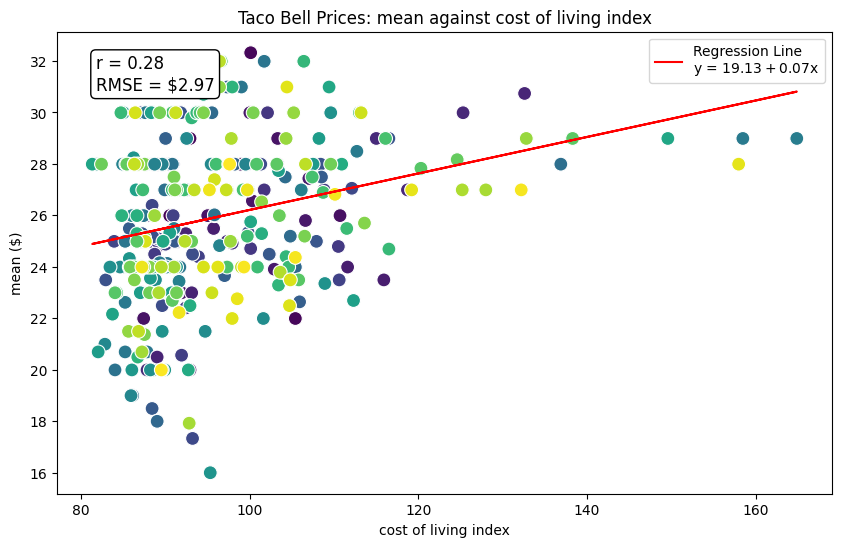

In [10]:
merged_city = city_coli.merge(city_distro, how = 'inner', on = ['city', 'state'])
plot_regression(merged_city, 'cost of living index', 'mean', hue_var = 'city', title_prefix='Taco Bell Prices: ', label_top_n=0)
# plot_regression(merged_city[merged_city['cost of living index'] < 121], 'cost of living index', 'mean', hue_var = 'city', title_prefix='Taco Bell Prices: ', label_top_n=0)

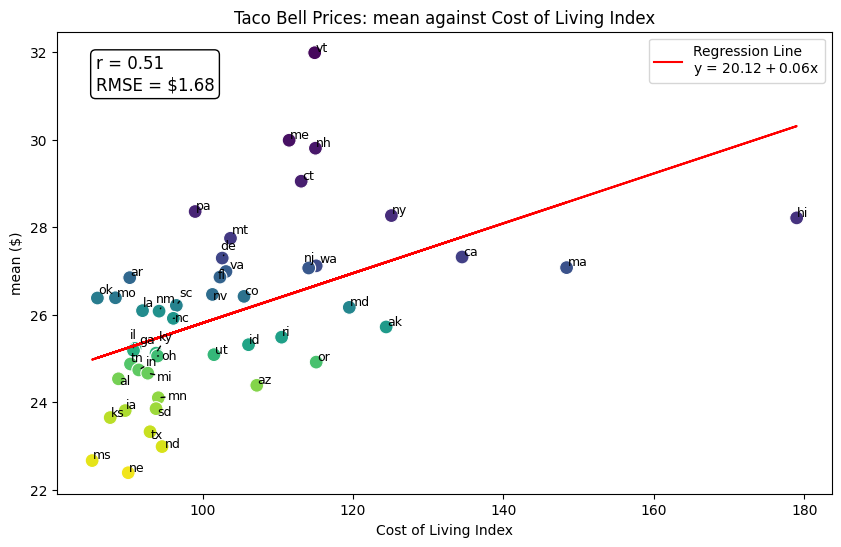

In [11]:
merged_state = state_distro.merge(state_coli, how = 'left', left_on = 'state', right_on = 'abbrev')
plot_regression(merged_state, 'Cost of Living Index', 'mean', title_prefix='Taco Bell Prices: ', label_top_n=50)
# plot_regression(merged_state[merged_state['state'] !='hi'], 'Cost of Living Index', 'mean', title_prefix='Taco Bell Prices: ', label_top_n=50)
# plot_regression(merged_state[merged_state['state'] !='vt'], 'Cost of Living Index', 'mean', title_prefix='Taco Bell Prices: ', label_top_n=50)

# Overpaying Analysis

In [12]:
merged_city['mean_coli'] = merged_city['cost of living index'].mean()
merged_city['pct_deviation_coli'] = (merged_city['cost of living index'] / merged_city['cost of living index'].mean()) - 1
merged_city['pct_deviation_price'] = (merged_city['mean'] / merged_city['mean'].mean()) - 1

# plot_regression(merged_city, 'pct_deviation_coli', 'pct_deviation_price', title_prefix='Taco Bell Prices: ', label_top_n=50)

merged_city['overpaying_delta'] = merged_city['pct_deviation_price'] - merged_city['pct_deviation_coli']
merged_city['overpaying_delta'].describe()

count   353.00
mean     -0.00
std       0.15
min      -0.60
25%      -0.08
50%       0.01
75%       0.09
max       0.31
Name: overpaying_delta, dtype: float64

In [13]:
merged_state['mean_coli'] = merged_state['Cost of Living Index'].mean()
merged_state['pct_deviation_coli'] = (merged_state['Cost of Living Index'] / merged_state['Cost of Living Index'].mean()) - 1
merged_state['pct_deviation_price'] = (merged_state['mean'] / merged_state['mean'].mean()) - 1

# plot_regression(merged_state, 'pct_deviation_coli', 'pct_deviation_price', title_prefix='Taco Bell Prices: ', label_top_n=50)
merged_state['overpaying_delta'] = merged_state['pct_deviation_price'] - merged_state['pct_deviation_coli']
merged_state['overpaying_delta'].describe()

count   47.00
mean     0.00
std      0.15
min     -0.64
25%     -0.04
50%      0.05
75%      0.08
max      0.18
Name: overpaying_delta, dtype: float64

In [28]:
## histogram

merged_state[['state', 'overpaying_delta']]

graph_col = 'overpaying_delta'
nbins = 20
title = 'state % deviations'
fig = px.histogram(merged_state, x=graph_col, nbins=nbins, title=title)
fig.update_traces(marker_line_color='black', marker_line_width=1.5)
fig.show()
# sns.histplot(merged_state['overpaying_delta'], kde=False, bins=10)


In [32]:
merged_city[['city', 'overpaying_delta']]

graph_col = 'overpaying_delta'
nbins = 50
title = 'city % deviations'
fig = px.histogram(merged_city, x=graph_col, nbins=nbins, title=title)
fig.update_traces(marker_line_color='black', marker_line_width=1.5)
fig.show()

# Variations in Pricing Analysis

In [14]:
def visualize_deviations(state_distro, bounds, graph_col = 'mean', nbins=20, title='Histogram of Mean Values by State'):
    
    # Calculate statistics
    mean_value = state_distro[graph_col].mean()
    # print(mean_value)
    median_value = state_distro[graph_col].median()  # Uncommented for proper usage
    
    # Adjust plus_val and minus_val based on mean
    plus_val = mean_value * (1 + bounds)  # Apply the plus_val percentage to the mean
    minus_val = mean_value * (1 - bounds)  # Apply the minus_val percentage to the mean
    
    # Calculate the percentage of data within the range
    pct_data_in_range = len(state_distro[(state_distro[graph_col] >= minus_val) & (state_distro[graph_col] <= plus_val)]) / len(state_distro)
    
    # Create the histogram
    fig = px.histogram(state_distro, x=graph_col, nbins=nbins, title=title)
    # Adding black lines around each bin
    fig.update_traces(marker_line_color='black', marker_line_width=1.5)

    # Add vertical lines for the mean, plus_val, and minus_val
    fig.add_vline(x=median_value, line=dict(color='green', dash='dash'))
    fig.add_vline(x=plus_val, line=dict(color='red', dash='dash'))
    fig.add_vline(x=minus_val, line=dict(color='purple', dash='dash'))
    
    # Add annotations for clarity
    fig.add_annotation(x=mean_value, y=0, text=graph_col, showarrow=True, arrowhead=1, ax=0, ay=-40)
    fig.add_annotation(x=plus_val, y=0, text="Plus Value", showarrow=True, arrowhead=1, ax=0, ay=-40)
    fig.add_annotation(x=minus_val, y=0, text="Minus Value", showarrow=True, arrowhead=1, ax=0, ay=-40)
    
    # Add annotation for the percentage of data within the range
    fig.add_annotation(
        text=f"""The amount of data within the bands is {round(pct_data_in_range * 100, 1)}%\n
              """,
        xref="paper", yref="paper",
        x=0, y=1,
        showarrow=False,
        font=dict(size=12),
        align="left",
        xanchor='left',
        yanchor='top'
    )
    
    # Show the figure
    fig.show()

        # text=f"""The amount of data within the bands is {round(pct_data_in_range * 100, 1)}%\n
        # The mean value is {mean_value}\n
        # The upper bound is {plus_val}\n
        # The lower bound is {minus_val}\n
        #       """,


In [15]:
bounds = .1
# visualize_deviations(state_distro, bounds, nbins=20, title='Histogram of Mean Values by State')

In [16]:
bounds = .15
visualize_deviations(state_distro, bounds, nbins=20, title='Histogram of Mean Values by State')

In [17]:
bounds = .15
visualize_deviations(working, bounds, graph_col = 'value', nbins=100, title = 'all prices')

In [18]:
# bounds = .15
# visualize_deviations(working[~working['state'].isin(['hi', 'ak'])], bounds, graph_col = 'value', nbins=100, title = 'all prices') 

In [19]:
working.columns

Index(['menu_section_name', 'primary_section_name', 'calories', 'item_code',
       'item_name', 'currencyIso', 'value', 'priceType', 'item_url',
       'store_id', 'location_url', 'state', 'city'],
      dtype='object')

In [20]:
state_distro

,state,item_name,mean,median,num_stores,nunique_prices,max,min,sd
0,vt,Supreme Taco Party Pack,31.99,31.99,1,1,31.99,31.99,NaN
1,me,Supreme Taco Party Pack,29.99,29.99,5,1,29.99,29.99,0.00
2,nh,Supreme Taco Party Pack,29.81,29.99,11,2,29.99,27.99,0.60
3,ct,Supreme Taco Party Pack,29.05,29.99,50,7,31.99,25.19,1.81
4,pa,Supreme Taco Party Pack,28.36,27.99,179,11,29.99,16.99,2.06
5,ny,Supreme Taco Party Pack,28.27,26.99,222,10,32.99,19.99,3.17
6,hi,Supreme Taco Party Pack,28.22,27.99,31,2,28.99,27.99,0.43
7,mt,Supreme Taco Party Pack,27.75,27.49,25,5,29.99,25.49,1.56
8,ca,Supreme Taco Party Pack,27.32,27.99,828,24,39.99,0.00,3.01
9,de,Supreme Taco Party Pack,27.30,27.99,13,2,27.99,23.49,1.69


In [21]:
state_coli['Cost of Living Index'].describe()

count    51.00
mean    104.00
std      18.24
min      85.30
25%      91.75
50%      96.50
75%     112.30
max     179.00
Name: Cost of Living Index, dtype: float64

In [22]:
city_coli['cost of living index'].describe()

count   510.00
mean     96.54
std      13.44
min      80.00
25%      88.22
50%      91.90
75%     100.70
max     178.60
Name: cost of living index, dtype: float64